In [31]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [32]:
def calc_normalMap(depth_map):
    """calculate normal map from depth map

    Args:
        depth_map (ndarray): depth map

    Returns:
        ndarray: normal map
    """
    d_im = depth_map.astype("float64")
    zy, zx = np.gradient(d_im)  
    # You may also consider using Sobel to get a joint Gaussian smoothing and differentation
    # to reduce noise
    #zx = cv2.Sobel(d_im, cv2.CV_64F, 1, 0, ksize=5)     
    #zy = cv2.Sobel(d_im, cv2.CV_64F, 0, 1, ksize=5)

    normal = np.dstack((-zx, -zy, np.ones_like(d_im)))
    n = np.linalg.norm(normal, axis=2)
    normal[:, :, 0] /= n
    normal[:, :, 1] /= n
    normal[:, :, 2] /= n

    # offset and rescale values to be in 0-255
    normal += 1
    normal /= 2
    # if show, comment
    normal *= 255
    # cv2.imwrite("normal.png", normal[:, :, ::-1])
    return normal[:,:,::-1].copy()


In [33]:
def add_noise_Guass(img, mean=0, var=0.01):  # 添加高斯噪声
    img_copy = img.copy()
    img = (img / 255).astype(np.float64)
    noise = np.random.normal(mean, var ** 0.5, img.shape)
    out_img = img + noise
    out_img = np.clip(out_img, 0.0, 1.0)
    out_img[img_copy==0] = 0
    out_img = out_img * 255
    return out_img.astype(np.uint8)

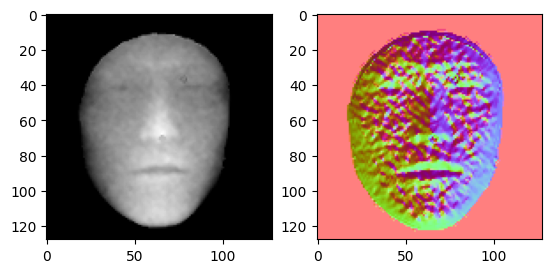

In [38]:
path = '/home/rz/data/lock3dface/dataset_1028_new_no_aug/train_set/001_Kinect_FE_1DEPTH/01_depth_normal.png'
img = cv.imread(path)[:, :, 0]
normal = calc_normalMap(img).astype(np.uint8)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(normal)

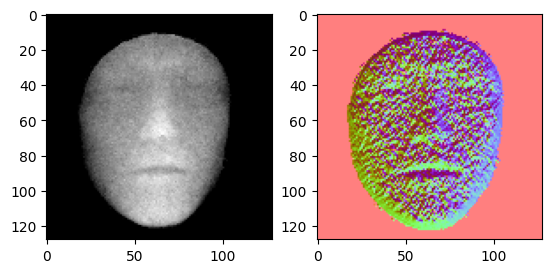

In [47]:
img_noisy = add_noise_Guass(img, var=0.001)
normal_noisy = calc_normalMap(img_noisy).astype(np.uint8)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(img_noisy, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(normal_noisy)